In [ ]:
# %pip install opensearch-py pyspark matplotlib scikit-learn seaborn pandas

Imports

In [53]:
import os
import sys

rootpath = os.path.abspath("/home/robertc/Git/pfun-cma-model")
if rootpath not in sys.path:
    sys.path.insert(0, rootpath)
from pfun_cma_model.embed import EmbedClient

Setup spark

In [54]:
from pyspark.sql import SparkSession
import os

# .config("spark.jars", os.path.join(rootpath, "pfun_cma_model/embed/pyspark_jars/opensearch-spark-30_2.13-1.0.1.jar"))
spark = SparkSession.builder \
    .config("spark.cores.max", "8") \
    .config("spark.kubernetes.container.image", "docker.io/bitnami/spark:3.5.0-debian-11-r0") \
    .config("spark.executor.instances", "4") \
.config("spark.jars", os.path.join(rootpath, "pfun_cma_model/embed/pyspark_jars/elasticsearch-spark-20_2.11-8.10.2.jar")) \
    .appName("pfun-cma-model-embed") \
    .getOrCreate()
spark.conf.set('spark.sql.shuffle.partitions', int(16 * 2.5))
spark.conf.set('spark.default.parallelism', 16)

Get Data from OpenSearch

In [57]:
osearc = EmbedClient(require_ssh_tunnel=False).opensearch_client
res = osearc.search(
    index="embeddings", body={"size": 6000, "_source": "embedding"}, scroll="2m"
)
scroll_id = res["_scroll_id"]
scroll_size = res["hits"]["total"]["value"]

Traceback (most recent call last):
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/http/client.py", line 1374, in getresponse
    response.begin()
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/http/client.py", line 287, in _read_status
    raise RemoteDisconnected("Remote end clos

ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7f9f3f473d00>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7f9f3f473d00>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
embeddings = [(d["_source"]["embedding"][0]["embedding"],) for d in res["hits"]["hits"]]

In [ ]:
def getDataFromOSWithSpark(index: str = "embeddings", sample_fraction: float | None = 0.1):
    #: Get data from opensearch (with spark)
    df = (
        spark.read.format("org.elasticsearch.spark.sql")
        .option("es.port", "9201")
        .option("es.net.ssl", "false")
        .option("es.nodes", "192.168.1.64")
        .load(f"{index}/float")
    )
    if sample_fraction is not None:
        # Create random sample of 10% of the data
        df_sample = df.sample(False, sample_fraction)
        return df_sample
    else:
        return df


# df = getDataFromOSWithSpark(sample_fraction=0.1)
# df.persist()
# df.show(5)

In [ ]:
from pyspark.sql.types import ArrayType, DoubleType, StructType, StructField

schema = StructType([StructField("list_features", ArrayType(DoubleType()))])
df = spark.createDataFrame(embeddings, schema=schema)

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# UDF to convert array into vector
vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df = df.withColumn("features", vector_udf("list_features"))

In [ ]:
df = df.repartition("features")
df.persist()

DataFrame[list_features: array<double>, features: vector]

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=8, seed=23)
model = kmeans.fit(df)

23/09/24 14:50:32 WARN TaskSetManager: Stage 66 contains a task of very large size (8450 KiB). The maximum recommended task size is 1000 KiB.


<Axes: xlabel='x', ylabel='y'>

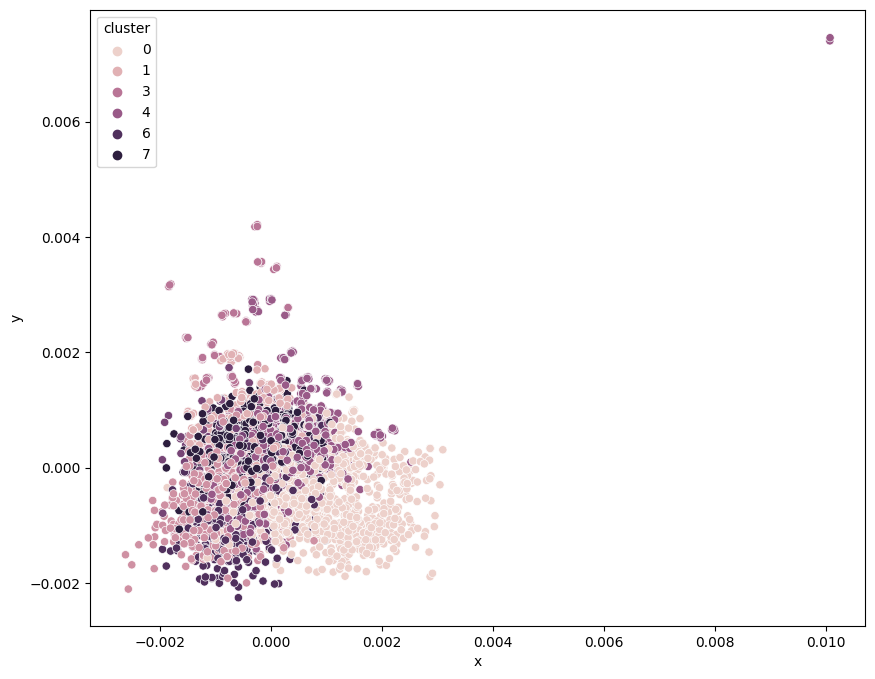

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

pca = PCA(n_components=2)
df_pandas = pd.DataFrame(
    model.transform(df)
    .rdd.map(lambda r: (float(r.features[0]), float(r.features[1]), int(r.prediction)))
    .collect(),
    columns=["x", "y", "cluster"],
)
df_pandas["x"], df_pandas["y"] = zip(*pca.fit_transform(df_pandas[["x", "y"]]))
plt.rc("figure", figsize=(10, 8))
sns.scatterplot(x="x", y="y", hue="cluster", data=df_pandas)

In [ ]:
pca.explained_variance_

array([7.74762139e-07, 6.84473725e-07])

In [ ]:
from pfun_cma_model.embed import encode
from pfun_cma_model.runtime.chalicelib.engine.cma_sleepwake import CMASleepWakeModel

cma = CMASleepWakeModel()
raw_text = cma.run().to_json()

queryVector = encode(raw_text)[0].tolist()
print(queryVector)

query = {
    "size": 1,
    "_source": {"includes": ["embedding"]},
    "query": {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.queryVector, doc['embedding']) + 1.0",
                "params": {
                    "queryVector": queryVector
                }
            }
        }
    }
}

response = osearc.search(index="embeddings", body=query, error_trace=True)

# Extract hit and score
hit = response['hits']['hits'][0]['_source']
score = response['hits']['hits'][0]['_score']
hit_id = response['hits']['hits'][0]['_id']

print(hit_id, hit, score)

/home/robertc/.pyenv/versions/3.10-dev/lib/python3.10/site-packages/pydantic/main.py:309: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


[0.09573450650344299, 0.0013389441469013007, 0.44194720734506504, 3.8255547054322874e-05, 0.014938791124713083, 3.8255547054322874e-05, 0.0, 3.8255547054322874e-05, 0.025745983167559296, 0.2471690895179801, 0.4431522570772762, 5.7383320581484315e-05, 0.014938791124713083, 5.7383320581484315e-05, 0.0, 0.3397666411629686, 0.42220734506503443, 0.2175592960979342, 0.00021040550879877583, 0.025745983167559296, 0.45855011476664115, 0.23245983167559295, 9.563886763580719e-05, 0.014938791124713083, 7.651109410864575e-05, 0.0, 0.5153596021423106, 0.4983550114766641, 0.39697781178270847, 0.00017214996174445295, 0.025745983167559296, 0.1386381025248661, 0.46635424636572304, 0.04560061208875287, 0.014938791124713083, 9.563886763580719e-05, 0.0, 0.11249043611323642, 0.3854628921193573, 0.45562356541698545, 0.0001530221882172915, 0.025745983167559296, 0.07559296097934201, 0.2175592960979342, 0.08043228768171384, 0.014938791124713083, 0.00011476664116296863, 0.0, 0.2275248661055853, 0.465149196633511

RequestError: RequestError(400, 'search_phase_execution_exception', 'runtime error')

In [ ]:
# pd.Series(queryVector).to_frame().T.to_clipboard(excel=True, sep=',', index=False, header=False)